# The Living Enterprise Dataset Inventory

The Enterprise Dataset Inventory (EDI) will be a living dataset that will be continually updated by DC government agencies in cooperation with the Office of the Chief Technology Officer (OCTO). These changes will be reflected in the data available on the [Open Data Portal](http://opendata.dc.gov/datasets/enterprise-dataset-inventory). 

To help residents understand and follow how the EDI changes over time, OCTO is publishing this version of the EDI analysis from the Chief Data Officer's Annual report. Unlike the [notebook from the final report](https://github.com/DCgov/enterprise-dataset-inventory/blob/master/fy18-annual-report/report-final.ipynb), which draws from archived data to allow residents to replicate the annual report published March 11, 2018, this notebook pulls data directly from the Open Data Portal, which is subject to change. 

The report was generated in Python 3.6.3 and requires the following packages: Pandas, NumPy, Matplotlib, and Seaborn.

This report also requires the following packages to pull data from the Open Data Portal API: io, requests.

Please report any issues to the GitHub repository [here](https://github.com/DCgov/enterprise-dataset-inventory/issues).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font='DejaVu Sans')

np.set_printoptions(suppress=True)

## Import Data

In [2]:
import io
import requests

url = 'https://opendata.arcgis.com/datasets/76a28737a6f84b3c92a421114acccca2_5.csv'
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

### When was the data last updated?

In [3]:
print('Data Last Pulled: '+pd.to_datetime(df.PUBLISHED_DATE).max().strftime("%Y/%m/%d"))

Data Last Pulled: 2018/03/11


### Assigning OCTO Data to Data Owners

The Office of the Chief Technology Officer (OCTO) maintains and publishes a large number of datasets for DC government agencies. For the sake of the inventory, OCTO largely attributed ownership of these datasets to the originating agency. This function cleans up data ownership and ensures that datasets are properly attributed in the analysis. Datasets maintained or published by OCTO that originate with non-DC government agencies (e.g., federal agencies) are assigned to OCTO as the data owner for the sake of this analysis.

In [4]:
not_dc  = ['AOC', 'BID', 'CENSUS', 'CT', 'MWCOG', 'NCPC', 'NGA', 'NPS', 'USDA', 'USDOT', 'USFWS', 'USGS', 'USPS', 'WDCEP', 'WMATA']

def data_owner(x):
    if x.AGENCY_ACRONYM in not_dc:
        return 'OCTO'
    elif (x.AGENCY_ACRONYM == 'OCTO') and ('DCEO' in x.DATA_OWNER):
        return 'DOEE'
    elif (x.AGENCY_ACRONYM == 'OCTO') and ('OA' in x.DATA_OWNER):
        return 'DCOA'
    elif (x.AGENCY_ACRONYM == 'OA'):
        return 'DCOA'
    elif (x.AGENCY_ACRONYM == 'OCTO') and ('NavTEQ' in x.DATA_OWNER):
        return 'OCTO'
    elif (x.AGENCY_ACRONYM == 'OCTO') and ('OCTO' not in x.DATA_OWNER):
        return x.DATA_OWNER
    elif (x.AGENCY_ACRONYM == 'OCTO') and ('PASS' in x.DATA_OWNER):
        return 'OCP'
    else:
        return x.AGENCY_ACRONYM
    
df['AGENCYCODE'] = df.apply(lambda x: data_owner(x), axis = 1)

## How many data sets did agencies enter?

Number of datasets recorded: 1640
OCTO    250
DCPS    168
DDOT    143
DOH     109
DOEE     76
OP       70
OCFO     55
DPW      39
DCRA     37
MPD      36
Name: AGENCYCODE, dtype: int64

Average Number of Data Sets: 21.6
Median Number of Data Sets: 9.5
Most Common Number of Data Sets: 2


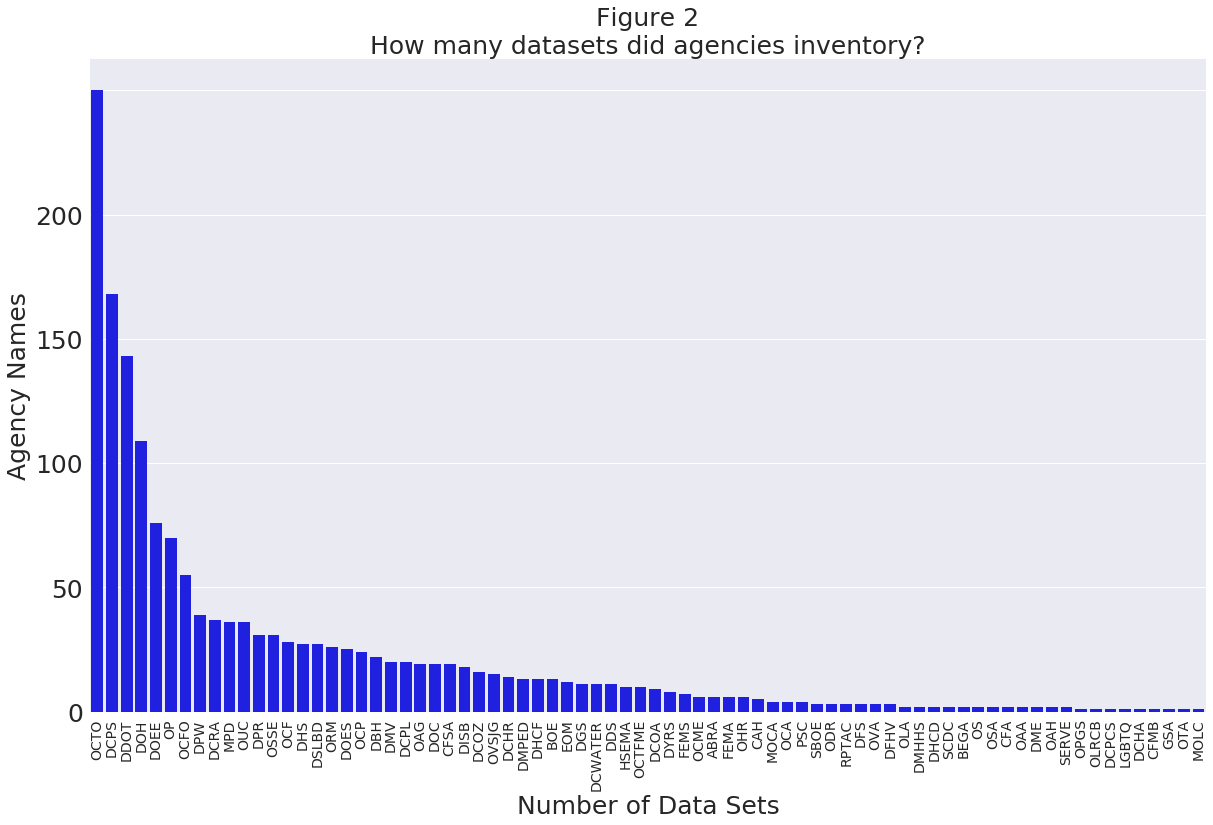

In [5]:
print('Number of datasets recorded: '+str(len(df)))

agency_counts = df.AGENCYCODE.value_counts()

print(agency_counts.sort_values(ascending=False).head(n=10))

print('\nAverage Number of Data Sets: '+str(round(df.AGENCYCODE.value_counts().mean(),1)))
print('Median Number of Data Sets: '+str(df.AGENCYCODE.value_counts().median()))
print('Most Common Number of Data Sets: '+str(df.AGENCYCODE.value_counts().mode().values[0]))

fig, ax = plt.subplots(figsize=(20,12))
sns.barplot(agency_counts.index, agency_counts.values, color='blue')
plt.xticks(rotation=90)
ax.set_xticklabels(agency_counts.index, fontsize=14)
ax.set_yticklabels(np.arange(0, 250, 50), fontsize=25)
ax.set_xlabel('Number of Data Sets', fontsize=25)
ax.set_ylabel('Agency Names', fontsize=25)
ax.set_title('Figure 2\nHow many datasets did agencies inventory?', fontsize=25)
plt.show()

## Dataset Classification

In [6]:
class_names = ['Open', 'Public Not Proactively Released', 'For District Government Use', 
               'Confidential', 'Restricted Confidential']
df['classification'] = df.DATASET_CLASSIFICATION_NAME.map({'Open': 0, 'Public Not Proactively Released': 1, 
                                                         'For District Government Use': 2, 'Confidential': 3, 
                                                         'Restricted Confidential': 4})

Number Classified
classification  DATASET_CLASSIFICATION_NAME    
0               Open                               708
1               Public Not Proactively Released    137
2               For District Government Use        193
3               Confidential                       508
4               Restricted Confidential             94
Name: classification, dtype: int64
Percent Classified
classification  DATASET_CLASSIFICATION_NAME    
0               Open                               43.2
1               Public Not Proactively Released     8.4
2               For District Government Use        11.8
3               Confidential                       31.0
4               Restricted Confidential             5.7
Name: classification, dtype: float64


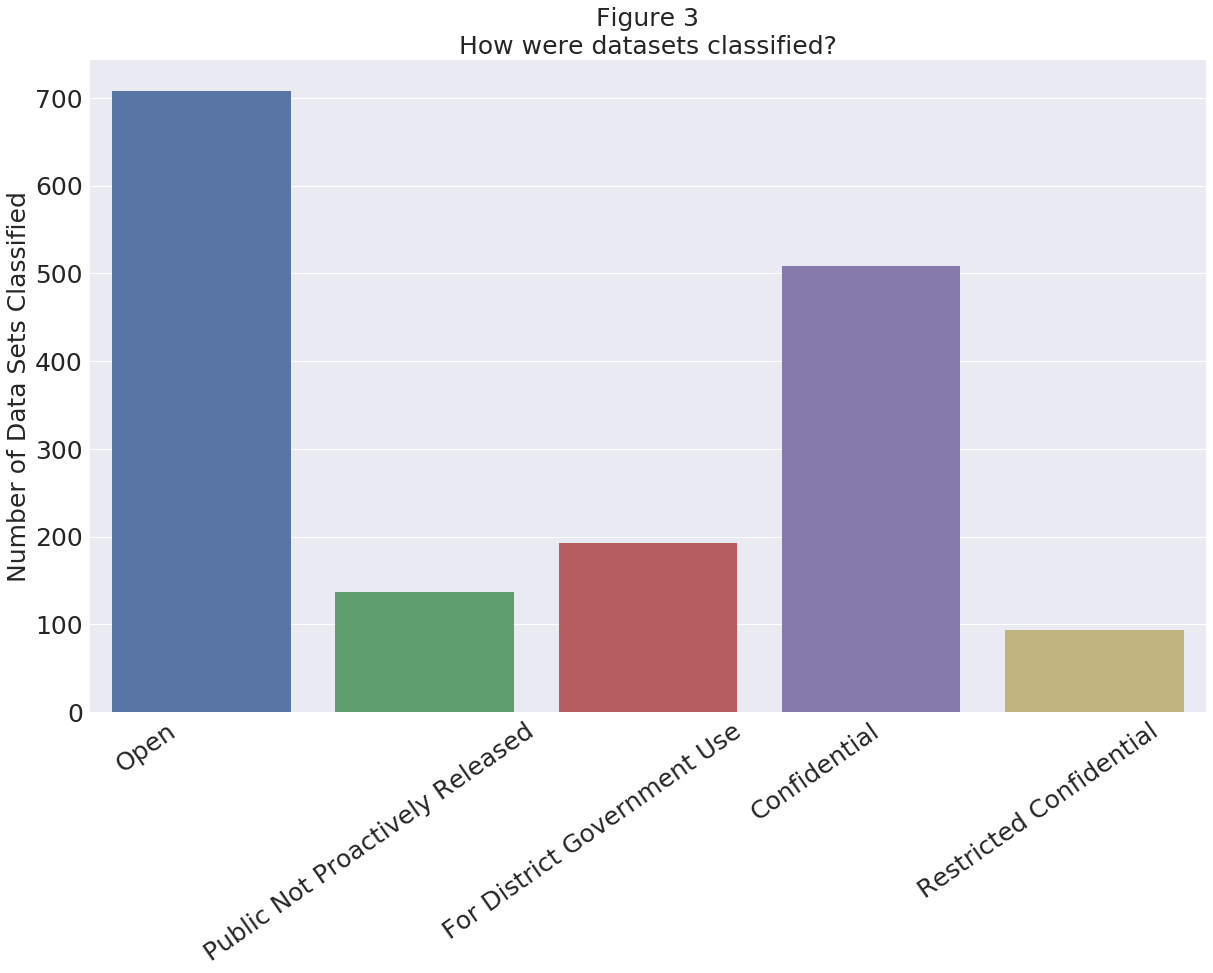

In [7]:
print('Number Classified')
print(np.round(df.groupby(['classification', 'DATASET_CLASSIFICATION_NAME']).classification.count(), 3))

print('Percent Classified')
print(100 * np.round(df.groupby(['classification', 'DATASET_CLASSIFICATION_NAME']).classification.count()/len(df), 3))

fig, ax = plt.subplots(figsize = (20,12))
sns.barplot(np.sort(df.classification.unique()), df.classification.value_counts().sort_index(), ax=ax)
ax.set_ylabel('Number of Data Sets Classified', fontsize=25)
ax.set_xticks(np.arange(-.25,4.75))
ax.set_xticklabels(class_names)
plt.xticks(rotation=35)
ax.tick_params(which = 'major', labelsize = 25)
ax.set_title('Figure 3\nHow were datasets classified?', fontsize = 25)

## How many Open Data Sets are in the Open Data Portal?

Data Sets in Open Data Portal: 517
Data Sets Classified 'Open': 708
Open Data Sets not in Open Data Portal: 191
No     191
Yes    517
Name: OPENDATA_PORTAL, dtype: int64
No     0.269774
Yes    0.730226
Name: OPENDATA_PORTAL, dtype: float64


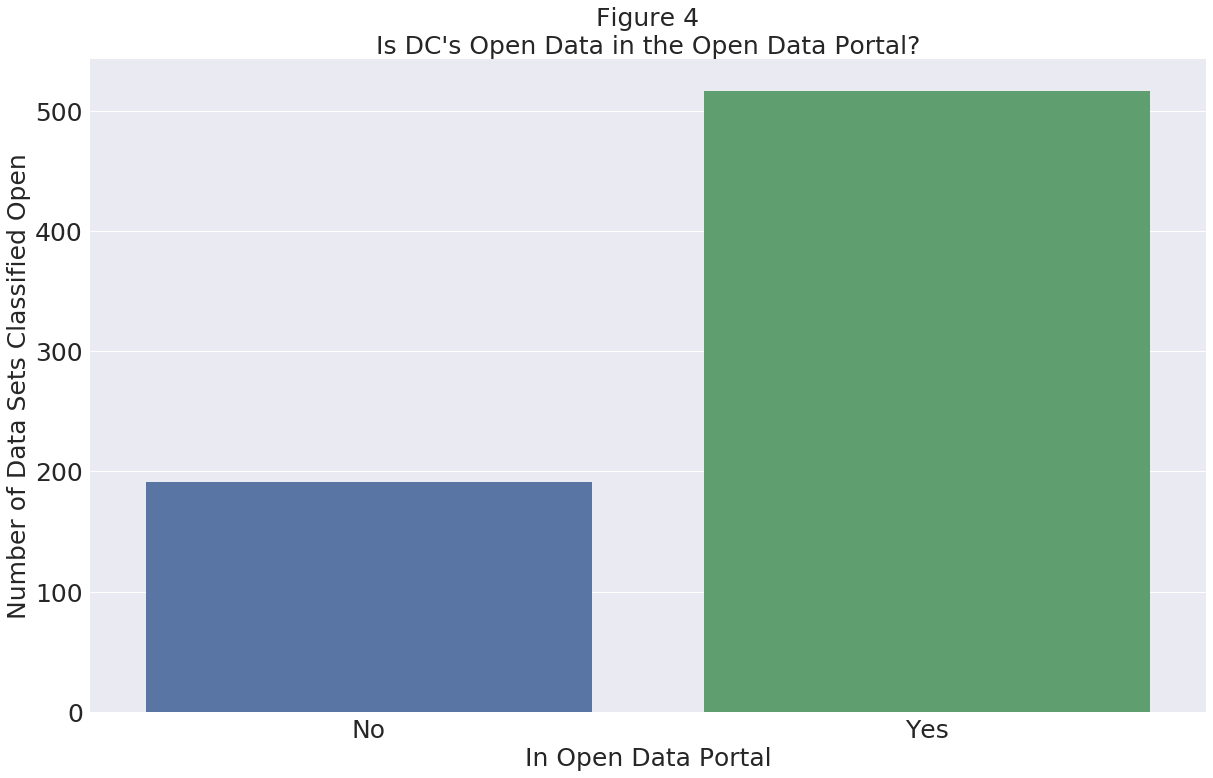

In [8]:
print('Data Sets in Open Data Portal: ' +str(df[df.OPENDATA_PORTAL=='Yes'].shape[0]))
print('Data Sets Classified \'Open\': ' +str(df[df.DATASET_CLASSIFICATION_NAME=='Open'].shape[0]))
print('Open Data Sets not in Open Data Portal: ' +str(df[(df.DATASET_CLASSIFICATION_NAME == 'Open') & (df.OPENDATA_PORTAL == 'No')].shape[0]))

open_data = df[df.DATASET_CLASSIFICATION_NAME=='Open']
print(open_data.OPENDATA_PORTAL.value_counts().sort_index())
print(open_data.OPENDATA_PORTAL.value_counts().sort_index()/len(open_data))

fig, (ax) = plt.subplots(1,1,figsize = (20,12))

sns.barplot(np.sort(open_data.OPENDATA_PORTAL.unique()), open_data.OPENDATA_PORTAL.value_counts().sort_index(), ax=ax)
ax.set_xlabel('In Open Data Portal', fontsize = 25)
ax.set_ylabel('Number of Data Sets Classified Open', fontsize=25)
ax.set_xticklabels(['No', 'Yes'])
ax.tick_params(which = 'major', labelsize = 25)
ax.set_title('Figure 4\nIs DC\'s Open Data in the Open Data Portal?', fontsize=25)

## Data Set Category

Government Operations                  207
Health                                 175
Transportation                         165
Education                              145
Public Safety                          122
Public Services                        122
Business and Economic Development      108
Administrative and Other Boundaries    102
Environment                             98
Utility and Communication               64
Property and Land                       60
Planning Land Use and Zoning            46
Financial                               45
Aerial Photography and Scanned Maps     42
Historic                                32
Facility and Structure                  22
Demographic                             21
Cultural and Society                    20
Recreation                              17
Location                                11
Technology                               6
Elevation                                5
Communication                            4
Basemap    

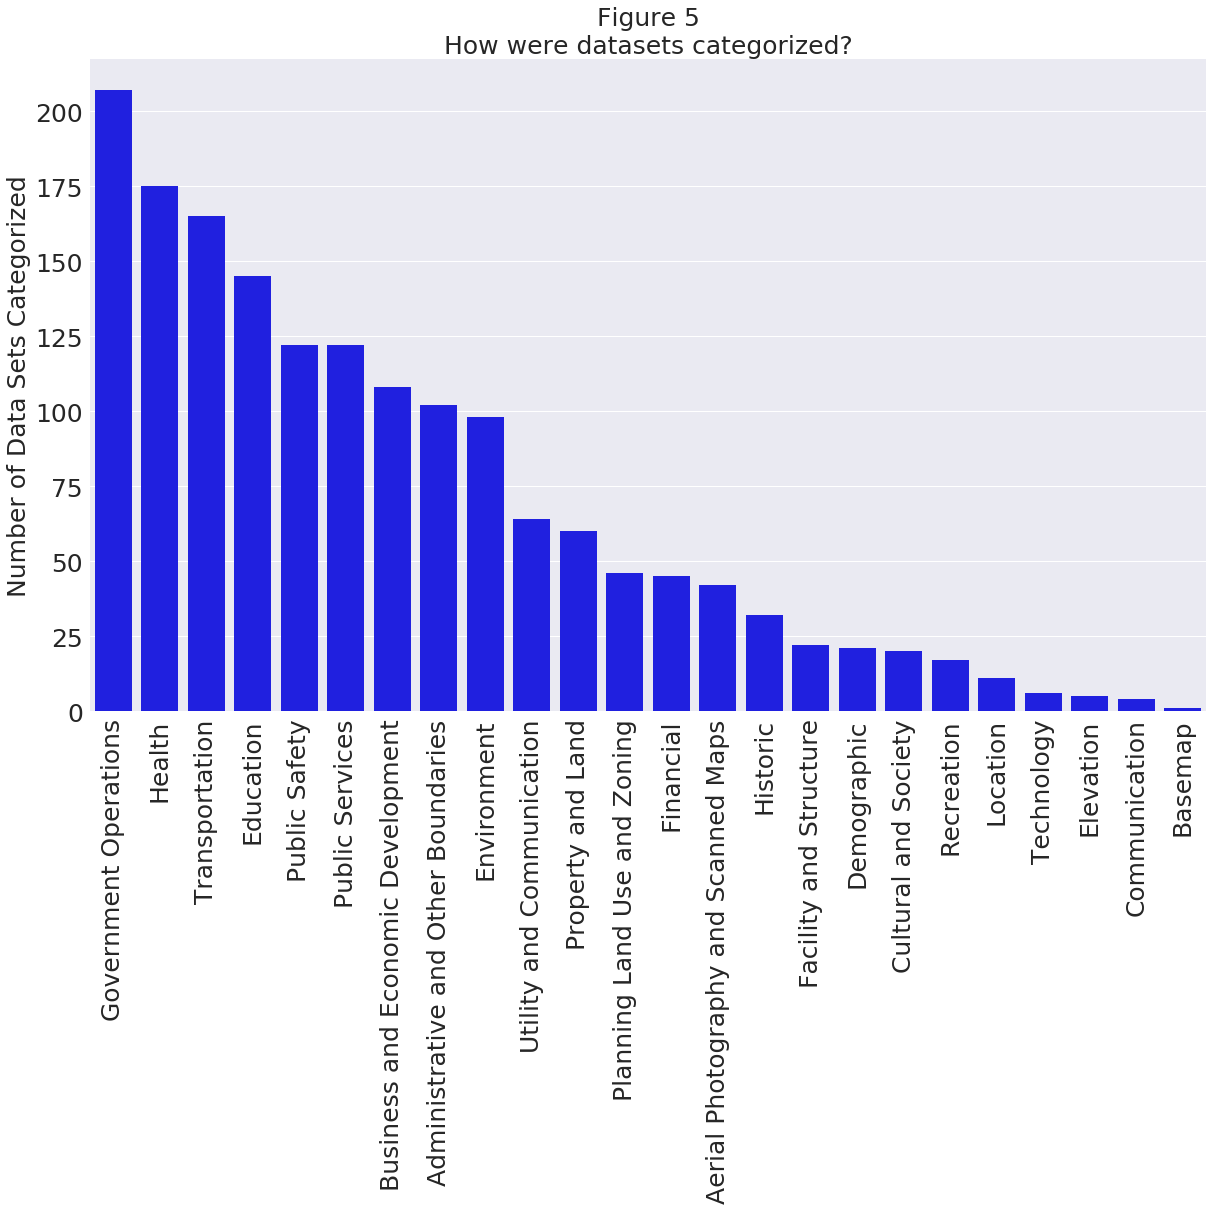

In [9]:
categories = pd.DataFrame(df.DATASET_CATEGORY.value_counts())
categories = categories[categories.index != '-1']

print(categories.DATASET_CATEGORY)

fig, ax = plt.subplots(figsize = (20,12))
sns.barplot(categories.index, categories.DATASET_CATEGORY, ax=ax, color = 'blue')
plt.xticks(rotation=90)
ax.tick_params(which = 'major', labelsize = 25)
ax.set_ylabel('Number of Data Sets Categorized', fontsize=25)
ax.set_title('Figure 5\nHow were datasets categorized?', fontsize=25)